In [1]:
# Import necessary functions.
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
import pandas as pd
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

In [2]:
# Initializing variables and Global variables.
PATH = 'GTSRB\\Final_Test\\Images'
FNAME = 'GT-final_test.csv'
Dataset = list()
X_test = list()
y_test = list()
IMSIZE = 49

In [3]:
# Create the class name based on the index.
with open(os.path.join('GTSRB\\Final_Training\\Training_Images', 'ReadMe.txt')) as f:
        content = f.readlines()
        
Classes = dict()

for line in content:
    if line[0].isdigit():
        if '=' in line:
            Classes[int(line.split('=')[0].strip())] = line.split('=')[1].strip()

In [4]:
# Load image filenames and label names.
test_annos = pd.read_csv(os.path.join(PATH, FNAME), sep=';')

In [5]:
# Creating one hot vector for each class.
categories = np.eye(43)

In [6]:
# Update the path according to the location.
def changePath(x):
    return f'{PATH}\\{x.Filename}'
    
test_annos['Filename'] = test_annos.apply(changePath,axis=1)

In [7]:
# Creating the training dataset.
for _, row in test_annos.iterrows():
    img = cv2.imread(row['Filename'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMSIZE, IMSIZE), interpolation = cv2.INTER_AREA)
    classid = categories[row['ClassId']]
    Dataset.append([np.array(img), np.array(classid)])

In [8]:
# Creating feature and label vectors.
for feature, label in Dataset:
    X_test.append(feature)
    y_test.append(label)

In [9]:
# Reshape the feature vector to fit the shape of the model input.
X_test = np.array(X_test).reshape(-1, IMSIZE, IMSIZE, 3)
y_test = np.array(y_test)

In [10]:
# Converting the features to 0 to 1 float values from 0 to 255 int values.
X_test = X_test/255.0

In [11]:
# Load the model.
deepNet = load_model('Saved_ephocs_v3.0\\deepNet.46-0.0982.h5')

In [12]:
# View model structure.
deepNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       7

In [13]:
# Evalueate the model againts test data.
deepNet.evaluate(X_test, y_test)

395/395 [==============================] - 5s 12ms/step - loss: 0.5294 - accuracy: 0.9760


[0.5293729305267334, 0.9760094881057739]

In [14]:
y_pred = deepNet.predict(X_test)

In [15]:
len(y_pred)

12630

In [16]:
y_max = list()

for p in y_pred:
    y_max.append(np.argmax(p))

In [17]:
y_actual = list()

for p in y_test:
    y_actual.append(np.argmax(p))

In [18]:
y_diff = np.array(y_max) - np.array(y_actual)

In [19]:
y_diff

array([ 0,  0,  0, ..., -1,  0,  0], dtype=int64)

In [20]:
wrong = [x for x in y_diff if x != 0]

In [21]:
100 - (len(wrong)/len(y_diff))*100

97.60095011876484

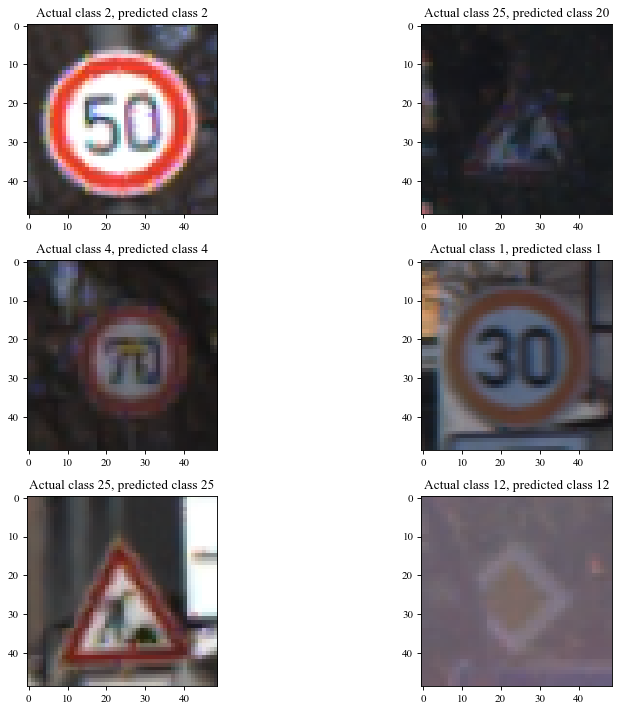

In [61]:
# Visualize predictions.

rows = 3
cols = 2
axes=[]

fig=plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

for i in range(6):
    
    j = random.randint(0, len(X_test))
    
    img = np.array(X_test[j])
    axes.append( fig.add_subplot(rows, cols, i+1) )
    actual = y_actual[j]
    predicted = y_pred[j]
    axes[-1].set_title('Actual class {}, predicted class {}'.format(actual, np.argmax(predicted)))
    plt.imshow(img)

fig.tight_layout()    
plt.show()

In [23]:
# Confustion matrix
cm = tf.math.confusion_matrix(
    y_actual, y_max, num_classes=43, weights=None, dtype=tf.dtypes.float64,
    name=None
)

In [24]:
np_cm = np.asarray(cm)

In [25]:
np_cm_dup = np.copy(np_cm)
for i in np.arange(43):
    total = np.sum(np_cm_dup[i])
    for j in np.arange(43):
        np_cm_dup[i, j] = np_cm_dup[i, j]*100.0/total

In [26]:
df_cm1 = pd.DataFrame(np_cm_dup, 
  index = Classes.values(),
  columns = Classes.values())

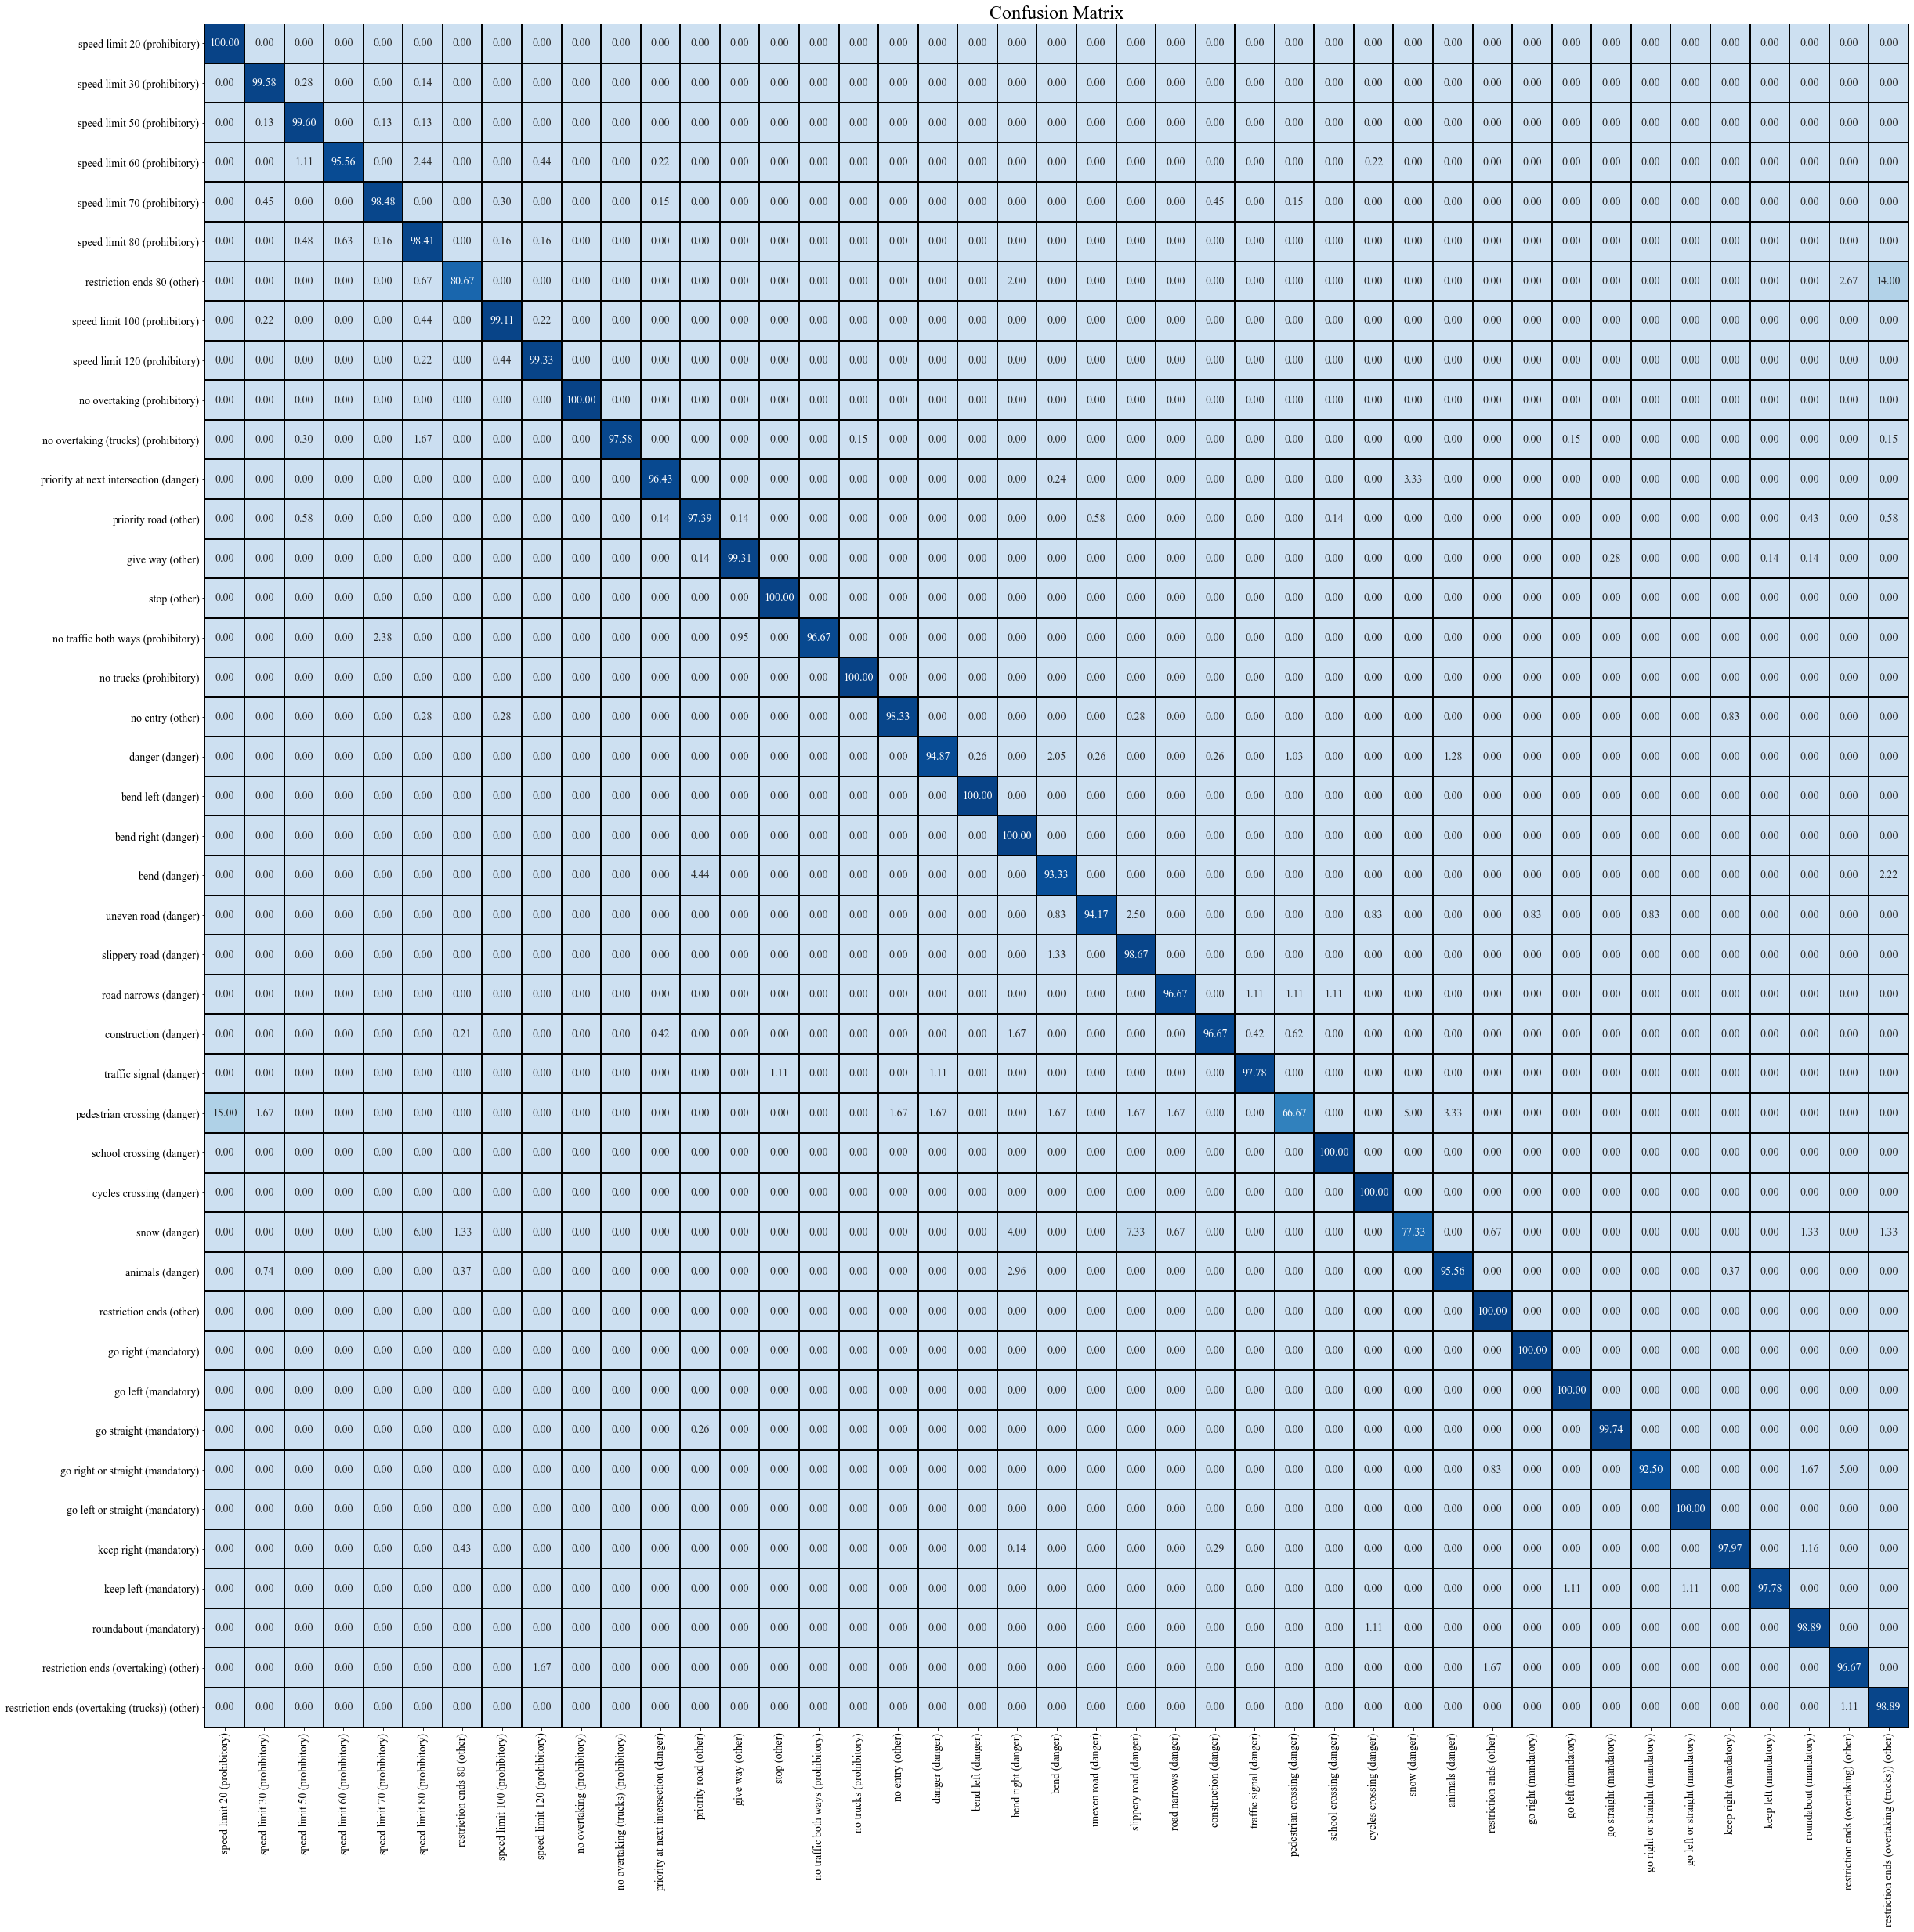

In [27]:
fig, ax = plt.subplots(figsize=(40,40), facecolor='#FFFFFF', edgecolor='black')
ax.set_aspect(1)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
res = sns.heatmap(df_cm1, annot=True, vmin=-30.0, vmax=110.0, fmt='.2f', 
                  cmap='Blues',cbar=False, linewidths=2.0, linecolor='Black',
                 annot_kws={"fontsize":14, "fontname":'Times New Roman'})
plt.title('Confusion Matrix',fontsize=24, fontname='Times New Roman')
plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.show()

In [28]:
# Precision.
precision = np.diag(np_cm)/np.sum(np_cm, axis=0)

In [29]:
precision

array([0.86956522, 0.98896552, 0.97903014, 0.99078341, 0.98934551,
       0.94224924, 0.9453125 , 0.98672566, 0.98893805, 1.        ,
       1.        , 0.98780488, 0.99115044, 0.99582173, 0.99264706,
       1.        , 0.99337748, 0.9971831 , 0.9919571 , 0.98360656,
       0.77586207, 0.86597938, 0.95762712, 0.90243902, 0.97752809,
       0.98723404, 0.98324022, 0.81632653, 0.98684211, 0.96774194,
       0.87218045, 0.97358491, 0.95238095, 0.99526066, 0.98360656,
       0.99488491, 0.99107143, 0.98360656, 0.99411765, 0.98876404,
       0.84761905, 0.84057971, 0.74789916])

In [30]:
# Recall.
recall = np.diag(np_cm)/np.sum(np_cm, axis=1)

In [31]:
recall

array([1.        , 0.99583333, 0.996     , 0.95555556, 0.98484848,
       0.98412698, 0.80666667, 0.99111111, 0.99333333, 1.        ,
       0.97575758, 0.96428571, 0.97391304, 0.99305556, 1.        ,
       0.96666667, 1.        , 0.98333333, 0.94871795, 1.        ,
       1.        , 0.93333333, 0.94166667, 0.98666667, 0.96666667,
       0.96666667, 0.97777778, 0.66666667, 1.        , 1.        ,
       0.77333333, 0.95555556, 1.        , 1.        , 1.        ,
       0.9974359 , 0.925     , 1.        , 0.97971014, 0.97777778,
       0.98888889, 0.96666667, 0.98888889])

In [32]:
precision_mean = np.mean(precision)
precision_mean

0.9535079107612243

In [33]:
recall_mean = np.mean(recall)
recall_mean

0.9652536489462676

In [34]:
# F1-Score.
f1_measure = 2*recall_mean*precision_mean/(precision_mean + recall_mean)
f1_measure

0.9593448289653166

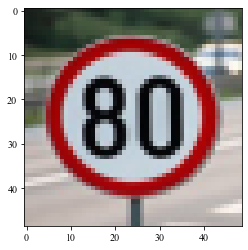

In [35]:
# Predicting some online sample images.

def readimg(pth):
    img = cv2.imread(pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMSIZE, IMSIZE), interpolation = cv2.INTER_AREA)
    plt.imshow(img)
    plt.show()
    return img

im = readimg('Online/80.jpg')

In [36]:
def pred(in_img):
    image = np.array(in_img).reshape(-1, IMSIZE, IMSIZE, 3)
    y = deepNet.predict(image)
    return Classes[np.argmax(y)]

result = pred(im)

In [37]:
print(result)

speed limit 80 (prohibitory)


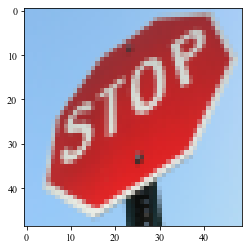

'stop (other)'

In [38]:
pred(readimg('Online/stop.jpg'))

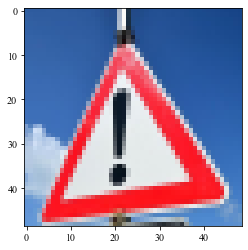

'danger (danger)'

In [39]:
pred(readimg('Online/danger.jpg'))

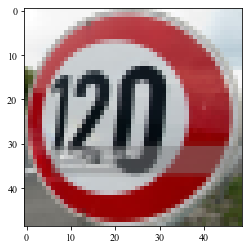

'speed limit 20 (prohibitory)'

In [40]:
pred(readimg('Online/120.jpg'))

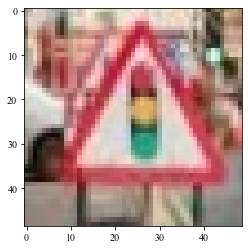

'traffic signal (danger)'

In [41]:
pred(readimg('Online/signal.jfif'))

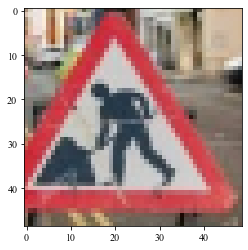

'pedestrian crossing (danger)'

In [42]:
pred(readimg('Online/consthead.jfif'))

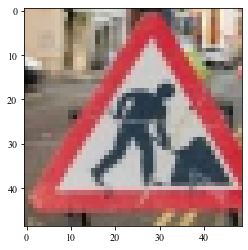

In [43]:
img = cv2.imread('Online/consthead.jfif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMSIZE, IMSIZE), interpolation = cv2.INTER_AREA)
img = cv2.flip(img, 1)
plt.imshow(img)
plt.show()

In [44]:
pred(img)

'construction (danger)'

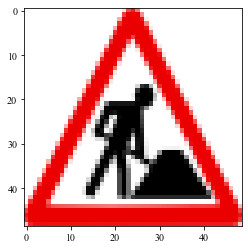

'construction (danger)'

In [45]:
pred(readimg('Online/const.png'))

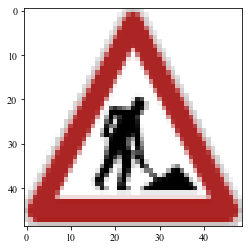

'construction (danger)'

In [46]:
pred(readimg('Online/images.png'))

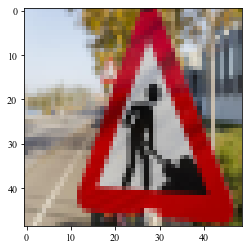

'construction (danger)'

In [47]:
img = cv2.imread('Online/cnst.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMSIZE, IMSIZE), interpolation = cv2.INTER_AREA)
img = cv2.flip(img, 1)
plt.imshow(img)
plt.show()
pred(img)